## 학습과정

1. Cell 스파이크 제거 후 큰 구간 cell 분리
2. Cell 분리 ( 2달 이하 Drop )
3. 노이즈 제거 (칼만필터)
4. 학습 데이터에 적용
5. 모델 학습
6. 모델 TEST

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 스파이크 제거 후, 큰 구간 cell 분리

TypeError: unhashable type: 'numpy.ndarray'

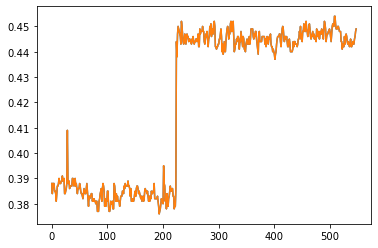

In [69]:
df = pd.read_csv("BANKS/m2_s2_bank_3a3f03ea56ed7e49b2570d5e8320044b__site_0d39d11b52565146a236a646d49133f4.csv")
df = df[df['CellNo']==2].reset_index(drop=True)


# 스파이크 제거
x=np.std(df['ResistValue'])
drop_idx=[]
for i in range(1,len(df)):
    if abs(df['ResistValue'][i]-df['ResistValue'][i-1])>x:
        drop_idx.append(i)
#print(drop_idx)
for i in drop_idx:
    df.drop(i, inplace=True)
df=df.reset_index(drop=True)
df.to_csv('cell_2.csv',index=False)
plt.plot(df['ResistValue'],label='original')
df['ResistValue'].plot()


# cell 분리
df=pd.read_csv('cell_2.csv')
x=np.std(df['ResistValue'])
divide_idx=[]
for i in range(1,len(df)):
    if abs(df['ResistValue'][i]-df['ResistValue'][i-1])>x:
        divide_idx.append(i)
#print(divide_idx)


cnt=1
last=0
for x in divide_idx:
    filename='cell_2_'+str(cnt)+'.csv'
    data=df[last:x]
    plt.plot(data, label=str(cnt)+'1st'"")
    data.to_csv(filename,index=False)
    cnt+=1
    last=x
    if x==divide_idx[-1]:
        filename='cell_2_'+str(cnt)+'.csv'
        data=df[last:]
        data.to_csv(filename,index=False)
        


In [ ]:
cnt=1
last=0
for x in divide_idx:
    filename='cell_2_'+str(cnt)+'.csv'
    data=df[last:x]
    if len(data)>120:
        plt.plot(data['ResistValue'], label='1st')
        data.to_csv(filename,index=False)
        cnt+=1
    last=x
    if x==divide_idx[-1]:
        filename='cell_2_'+str(cnt)+'.csv'
        data=df[last:]
        if len(data)>120:
            plt.plot(data['ResistValue'], label='2nd')
            data.to_csv(filename,index=False)
plt.legend()
plt.show()


# 2. 결측치 15일 이상인 경우 구분

In [51]:
df=pd.read_csv('cell_2_1.csv')
df = df[['KeyTime','CellNo','ResistValue']]
df['KeyTime']=pd.to_datetime(df['KeyTime'],format="%Y/%m/%d")


cut_date_value=15
min_date=120
cnt=1
last=0
cell= df
for i in range(1,len(cell)):
    # 장기간 비어있는 cell, index 찾기
    if abs(cell['KeyTime'][i]-cell['KeyTime'][i-1]).days>cut_date_value:
        
        filename='cell_2_'+str(cnt)+'.csv'
        data = cell[last:i].reset_index(drop=True)
        # Data의 측정 기간이 2달 이상인 경우
        if len(data)>120:
            data.to_csv(filename, index=False)
            cnt+=1
            last=i
        last=i

filename='cell_2_'+str(cnt)+'.csv'
data=cell[last:]
if len(data)>120:
    data.to_csv(filename, index=False)
            
        

([<matplotlib.axis.YTick at 0x283375b2390>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

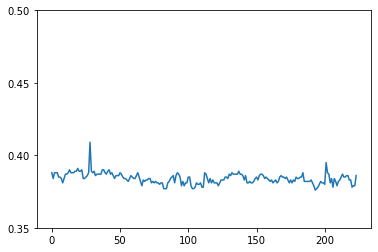

In [42]:
cell_2_1=pd.read_csv("cell_2_1.csv")
cell_2_1['ResistValue'].plot()
plt.yticks(np.arange(0.35,0.5,0.05))

([<matplotlib.axis.YTick at 0x28337056cf8>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

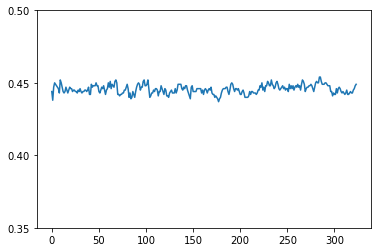

In [43]:
cell_2_2=pd.read_csv("cell_2_2.csv")
cell_2_2['ResistValue'].plot()
plt.yticks(np.arange(0.35,0.5,0.05))

# 결측치 채워넣기 / 과다 측정 삭제하기

In [91]:
chk_cell = pd.read_csv('TEST/10_cell_1.csv')

# 채워넣기
for i in range(1,(len(chk_cell)-1)):
    if abs(pd.Timestamp(chk_cell['KeyTime'][i]) - pd.Timestamp(chk_cell['KeyTime'][i-1])).days>= 1 :        
        # 비어있는 날짜 내부저항 -> 앞,뒤 평균값
        avg_resist = (chk_cell['ResistValue'][i-1]+chk_cell['ResistValue'][i])/2
        cnt=0
        while cnt<=1:
            day=1
            idx=i
            new_data={'KeyTime': pd.Timestamp(chk_cell['KeyTime'][i-1])+pd.Timedelta('12H'),
                     'CellNo':chk_cell['CellNo'][i-1],
                     'ResistValue':avg_resist}
            if (str(new_data['KeyTime'])[:10])== str(chk_cell['KeyTime'][:10]):
                cnt+=1
            #print(new_data['KeyTime'])
            else:
                tmp1=chk_cell[chk_cell.index<idx]
                tmp2=chk_cell[chk_cell.index>=idx]
                print(tmp1, tmp2)
                chk_cell = tmp1.append(new_data, ignore_index=True).append(tmp2,ignore_index=True)
                idx+=1
                cnt+=1
            #print('Added Time',chk_cell['KeyTime'][i])
        #print(chk_cell[99:110])
chk_cell.to_csv('cell_2_1_adj.csv', index=False)

# 삭제하기
# 하루 2번 측정되었는지 확인
cnt_date=1
chk=pd.Timestamp(chk_cell['KeyTime'][0]).day
have_to_remove=[]
for i in range(1,len(chk_cell)):    
    # 하루 2번 정상적으로 측정되었는지 확인하기
    if chk == pd.Timestamp(chk_cell['KeyTime'][i]).day:
        cnt_date+=1
        if cnt_date>2:
            have_to_remove.append(pd.Timestamp(chk_cell['KeyTime'][i]))
            #print('erased Time',chk_cell['KeyTime'][i])
            chk_cell.drop(i,axis=0,inplace=True)
            
    else:
        cnt_date=1
        chk=pd.Timestamp(chk_cell['KeyTime'][i]).day
chk_cell.to_csv('cell_10_1.csv', index=False)

               KeyTime  CellNo  ResistValue  VoltValue  TempValue
0  2020-02-12 13:35:54      10        0.381       4.45      -20.0
1  2020-02-13 01:35:00      10        0.380       4.45      -20.0
2  2020-02-13 13:34:15      10        0.377       4.44      -20.0
3  2020-02-14 01:33:32      10        0.378       4.44      -20.0
4  2020-02-14 13:32:51      10        0.377       4.43      -20.0
5  2020-02-15 01:32:15      10        0.376       4.45      -20.0
6  2020-02-15 13:31:29      10        0.377       4.45      -20.0                  KeyTime  CellNo  ResistValue  VoltValue  TempValue
7    2020-02-17 01:29:11      10        0.379       4.45      -20.0
8    2020-02-17 13:28:21      10        0.378       4.45      -20.0
9    2020-02-18 01:27:32      10        0.377       4.44      -20.0
10   2020-02-18 13:26:50      10        0.378       4.45      -20.0
11   2020-02-19 01:26:16      10        0.376       4.45      -20.0
..                   ...     ...          ...        ...        

[128 rows x 5 columns]                  KeyTime  CellNo  ResistValue  VoltValue  TempValue
128  2020-05-07 12:45:17      10        0.374       4.44      -20.0
129  2020-05-08 00:44:22      10        0.372       4.45      -20.0
130  2020-05-08 12:43:43      10        0.371       4.46      -20.0
131  2020-05-09 00:43:00      10        0.373       4.44      -20.0
132  2020-05-09 12:42:22      10        0.376       4.44      -20.0
..                   ...     ...          ...        ...        ...
233  2020-06-30 16:46:12      10        0.371       4.45      -20.0
234  2020-07-01 04:45:49      10        0.370       4.45      -20.0
235  2020-07-01 16:45:20      10        0.374       4.44      -20.0
236  2020-07-02 04:44:44      10        0.373       4.45      -20.0
237  2020-07-02 13:37:35      10        0.373       4.44      -20.0

[110 rows x 5 columns]
                 KeyTime  CellNo  ResistValue  VoltValue  TempValue
0    2020-02-12 13:35:54      10       0.3810       4.45      -20.0
1

                 KeyTime  CellNo  ResistValue  VoltValue  TempValue
0    2020-02-12 13:35:54      10     0.381000       4.45      -20.0
1    2020-02-13 01:35:00      10     0.380000       4.45      -20.0
2    2020-02-13 13:34:15      10     0.377000       4.44      -20.0
3    2020-02-14 01:33:32      10     0.378000       4.44      -20.0
4    2020-02-14 13:32:51      10     0.377000       4.43      -20.0
..                   ...     ...          ...        ...        ...
143  2020-04-16 13:30:45      10     0.373994        NaN        NaN
144  2020-04-17 01:30:45      10     0.373997        NaN        NaN
145  2020-04-17 01:30:45      10     0.373997        NaN        NaN
146  2020-04-17 13:30:45      10     0.373999        NaN        NaN
147  2020-04-17 13:30:45      10     0.373999        NaN        NaN

[148 rows x 5 columns]                  KeyTime  CellNo  ResistValue  VoltValue  TempValue
148  2020-05-07 12:45:17      10        0.374       4.44      -20.0
149  2020-05-08 00:44:22

[168 rows x 5 columns]                  KeyTime  CellNo  ResistValue  VoltValue  TempValue
168  2020-05-07 12:45:17      10        0.374       4.44      -20.0
169  2020-05-08 00:44:22      10        0.372       4.45      -20.0
170  2020-05-08 12:43:43      10        0.371       4.46      -20.0
171  2020-05-09 00:43:00      10        0.373       4.44      -20.0
172  2020-05-09 12:42:22      10        0.376       4.44      -20.0
..                   ...     ...          ...        ...        ...
273  2020-06-30 16:46:12      10        0.371       4.45      -20.0
274  2020-07-01 04:45:49      10        0.370       4.45      -20.0
275  2020-07-01 16:45:20      10        0.374       4.44      -20.0
276  2020-07-02 04:44:44      10        0.373       4.45      -20.0
277  2020-07-02 13:37:35      10        0.373       4.44      -20.0

[110 rows x 5 columns]
                 KeyTime  CellNo  ResistValue  VoltValue  TempValue
0    2020-02-12 13:35:54      10        0.381       4.45      -20.0
1

[188 rows x 5 columns]                  KeyTime  CellNo  ResistValue  VoltValue  TempValue
188  2020-04-28 01:30:45      10        0.374        NaN        NaN
189  2020-05-07 12:45:17      10        0.374       4.44      -20.0
190  2020-05-08 00:44:22      10        0.372       4.45      -20.0
191  2020-05-08 12:43:43      10        0.371       4.46      -20.0
192  2020-05-09 00:43:00      10        0.373       4.44      -20.0
..                   ...     ...          ...        ...        ...
294  2020-06-30 16:46:12      10        0.371       4.45      -20.0
295  2020-07-01 04:45:49      10        0.370       4.45      -20.0
296  2020-07-01 16:45:20      10        0.374       4.44      -20.0
297  2020-07-02 04:44:44      10        0.373       4.45      -20.0
298  2020-07-02 13:37:35      10        0.373       4.44      -20.0

[111 rows x 5 columns]
                 KeyTime  CellNo  ResistValue  VoltValue  TempValue
0    2020-02-12 13:35:54      10        0.381       4.45      -20.0
1

[210 rows x 5 columns]                  KeyTime  CellNo  ResistValue  VoltValue  TempValue
210  2020-05-03 13:30:45      10        0.374        NaN        NaN
211  2020-05-07 12:45:17      10        0.374       4.44      -20.0
212  2020-05-08 00:44:22      10        0.372       4.45      -20.0
213  2020-05-08 12:43:43      10        0.371       4.46      -20.0
214  2020-05-09 00:43:00      10        0.373       4.44      -20.0
..                   ...     ...          ...        ...        ...
316  2020-06-30 16:46:12      10        0.371       4.45      -20.0
317  2020-07-01 04:45:49      10        0.370       4.45      -20.0
318  2020-07-01 16:45:20      10        0.374       4.44      -20.0
319  2020-07-02 04:44:44      10        0.373       4.45      -20.0
320  2020-07-02 13:37:35      10        0.373       4.44      -20.0

[111 rows x 5 columns]
                 KeyTime  CellNo  ResistValue  VoltValue  TempValue
0    2020-02-12 13:35:54      10        0.381       4.45      -20.0
1

# 3. 노이즈제거 (칼만-필터)

In [23]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P
# Initialization for system model.
A = 1
H = 1
Q = 0.00001
R = 0.01
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

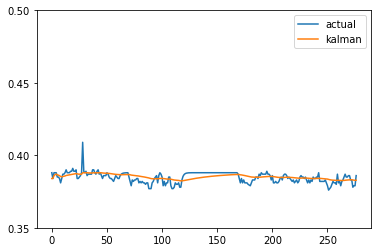

In [48]:
# 전처리 이전 cell
df = pd.read_csv("cell_2_1_adjv2.csv")
plt.plot(df['ResistValue'], label='actual')
df = df['ResistValue']

# 칼만 필터 적용 후
n_samples = len(df)
x_0 = df[1]
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = df[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

df = r_esti_save
df=pd.DataFrame(df)
plt.plot(df, label='kalman')
plt.yticks(np.arange(0.35,0.5,0.05))
plt.legend()
plt.show()

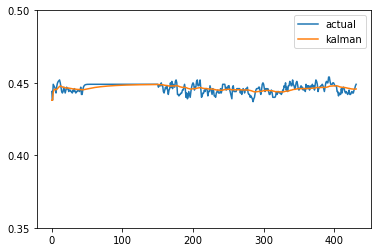

In [49]:
# 전처리 이후 cell
df = pd.read_csv("cell_2_2_adjv2.csv")
plt.plot(df['ResistValue'], label='actual')
df = df['ResistValue']

# 칼만 필터 적용 후
n_samples = len(df)
x_0 = df[1]
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = df[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

df = r_esti_save
df=pd.DataFrame(df)
plt.plot(df, label='kalman')
plt.yticks(np.arange(0.35,0.5,0.05))
plt.legend()
plt.show()